In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
import collections
import gym
from runstats import *
import random

random.seed(123456)
np.random.seed(123456)

In [8]:
def r(beta, sigma, T, t, s, q):
    """
    Parameters
    ----------
      gamma : float
        discount factor.
      sigma : float
        price volatility.
      T : float
        Total time.
      t : float
        Start time.
      s : float
        Initial value of future/stock price.
      q : float 
         MM: int?
        in Avellaneda q = # stocks held

    Return:
    ----------
    
      r : float
        in Avellaneda, r = indiference/reservation price
    """
    return s - q*beta*sigma**2*(T-t) 
    #JK: eq. (29) in paper

def l(A, k, d):
    '''
    Parameters
    ----------
      A : float
        in Avellaneda A = \lambda/\alpha, where alpha is as above,
        and lambda is the constant frequency of market buy and sell orders.
      k : float
        in Avellaneda k = alpha*K, where alpha ~ 1.5, 
        and K is such that \delta p ~ Kln(Q) for a market order of size Q
      d : float
        in Avellaneda, d=distance to the mid price
    
    Return
    -------
    
      l : float:
        in Avellaneda, l = lambda = Poisson intensity at which our agent’s orders are
        executed.
    '''
    return A*np.exp(-k*d) 
    #JK: eq. (12)


In [9]:
# MS: Using a discrete action space similar to the Market Making via Reinforcement Learning paper (https://arxiv.org/pdf/1804.04216.pdf, Section 3 - p.3)
actions_num = 20   #MS: So the range of possibilities goes from 0.3% to 3% from TOB
actions = range(21)
max_abs_dif = 4
max_abs_spread = 20

# make the simulation into an RL environment:
import gym
import numpy as np
#from stable_baselines3.common.vec_env import DummyVecEnv

    
s0 = 100
T = 1. # Total time.
sigma = 2.  # Standard deviation.
dt = .005  # Time step.
beta = 0.5
kappa = beta * 2
k = 1.5
A = 137.45


def spread(beta, sigma, T_t, k):
    return beta*sigma**2*(T_t) + 2/beta*np.log(1+beta/k)

def r(beta, sigma, T_t, s, q):
    return s - q*beta*sigma**2*(T_t)

def v(beta, c, q, s, T, t, sigma):
    return -np.exp(-beta*c)*np.exp(-beta*q*s)*np.exp((beta**2 * q**2 * sigma**2 * (T - t))/2)

class AvellanedaEnv:
    def __init__(self, s0, T, dt, sigma, beta, k, A,kappa, seed=0, is_discrete=True):
        '''
        Parameters
        ----------
        s : float
            Initial value of future/stock price.
        b : float
            Initial value of 'brecha'.
        T : float
            Total time.
        dt : float
            Time subdivision.
        sigma : float
            price volatility.
        gamma : float
            discount factor.
        k : float
            in Avellaneda k = alpha*K, where alpha ~ 1.5, 
            and K is such that \delta p ~ Kln(Q) for a market order of size Q
        A : float
            in Avellaneda A = \lambda/\alpha, where alpha is as above,
            and lambda is the constant frequency of market buy and sell orders.
    
        '''
        self.s0 = s0
        self.T = T
        self.dt = dt
        self.sigma = sigma
        self.beta = beta
        self.k = k
        self.A = A
        self.sqrtdt = np.sqrt(dt)
        self.kappa = kappa
        self.is_discrete = is_discrete
        self.stats = runstats.ExponentialStatistics(decay=0.999)

        self.dws = collections.deque(maxlen=3*int(self.T/self.dt))
        self.sum_dws = 0.0

        np.random.seed(seed)

        # observation space: s (price), q, T-t (time remaining)
        self.observation_space = gym.spaces.Box(low=np.array([0.0, -math.inf, 0.0]),
                                     high=np.array([math.inf, math.inf,T]),
                                     dtype=np.float32)
        # action space: spread, ds
        self.action_space = gym.spaces.Discrete(actions_num)
        
        self.metadata = None # useless field
        
    def reset(self):
        self.s = self.s0
        self.q = 0.0
        self.t = 0.0
        self.w = 0.0
        self.int_s = 0
        self.n = int(T/dt)
        self.c_ = 0.0
        return (self.int_s,self.q,int((self.T-self.t)/self.dt),self.s,self.q,self.T-self.t)
        
    def step(self, action):
        if self.is_discrete:
            despl = (action-(actions_num-1)/2)*max_abs_dif/(actions_num-1)
        else:
            despl = action
            
        ba_spread = spread(self.beta,self.sigma,self.T-self.t,self.k)

        bid = self.s - despl - ba_spread/2
        ask = self.s - despl + ba_spread/2
                
        db = self.s - bid
        da = ask - self.s
        
        lb = l(A, k, db)
        la = l(A, k, da)
        
        dnb = 1 if np.random.uniform() <= lb * self.dt else 0
        dna = 1 if np.random.uniform() <= la * self.dt else 0
        self.q += dnb - dna

        self.c_ += -dnb * bid + dna * ask # cash
        
        self.int_s += (1 if np.random.uniform() < 0.5 else -1)
        self.s = self.sigma * self.sqrtdt * self.int_s + self.s0

        previous_w = self.w
        self.w = self.c_ + self.q * self.s
        
        dw = (self.w - previous_w)
        
        self.stats.push(dw)
        """
        if len(self.dws) >= 3*int(self.T/self.dt):
            aux = self.dws.popleft()
            self.sum_dws -= aux
            self.sum_dws += dw
            self.dws.append(dw)
            mean_dws = self.sum_dws / (3*int(self.T/self.dt))
        else:
            self.sum_dws += dw
            self.dws.append(dw)
            mean_dws = self.sum_dws / len(self.dws)

        """
        #if self.t >= self.T:
        reward = dw - self.kappa/2 * (dw - self.stats.mean())**2
        #reward = - self.kappa/2 * (dw - self.stats.mean())**2
        
        self.t += self.dt
           
        return (self.int_s,self.q,int((self.T-self.t)/self.dt),self.s,self.q,self.T-self.t), reward, self.t >= self.T, {'w':self.w}

In [10]:
'''
Q-learning approach for different RL problems
as part of the basic series on reinforcement learning @
https://github.com/vmayoral/basic_reinforcement_learning
Inspired by https://gym.openai.com/evaluations/eval_kWknKOkPQ7izrixdhriurA
        @author: Victor Mayoral Vilches <victor@erlerobotics.com>
'''
import gym
import math
import numpy
import random
import pandas
import runstats


class QLearn:
    def __init__(self, actions, alpha, gamma):
        self.q = {}
        self.epsilon = 0.15  # exploration constant
        self.alpha = alpha      # discount constant
        self.gamma = gamma      # discount factor
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        '''
        Q-learning:
            Q(s, a) += alpha * (reward(s,a) + max(Q(s') - Q(s,a))
        '''
        oldv = self.q.get((state, action), None)
        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def predict(self,state):
        return self.chooseAction(state)

    def chooseAction(self, state, return_q=False):
        q = [self.getQ(state, a) for a in self.actions]
        maxQ = max(q)

        if random.random() < self.epsilon:
            minQ = min(q); mag = max(abs(minQ), abs(maxQ))
            # add random values to all the actions, recalculate maxQ
            q = [q[i] + random.random() * mag - .5 * mag for i in range(len(self.actions))]
            maxQ = max(q)

        count = q.count(maxQ)
        # In case there're several state-action max values
        # we select a random one among them
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            i = random.choice(best)
        else:
            i = q.index(maxQ)

        action = self.actions[i]
        if return_q: # if they want it, give it!
            return action, q
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma*maxqnew)

def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return numpy.digitize(x=[value], bins=bins)[0]


In [ ]:
if __name__ == '__main__':

    env = AvellanedaEnv(s0, T, dt, sigma, beta, k, A, kappa)

    last_time_steps = numpy.ndarray(0)

    # The Q-learn algorithm
    qlearn = QLearn(actions=range(actions_num),
                    alpha=0.6, gamma=1)

    done = False
    i = 0
  
    episodes = 5000000
    ws = collections.deque(maxlen=100)
    ws2 = collections.deque(maxlen=100)
    sum_ws = 0.0
    sum_ws2 = 0.0    
    var_ws = 0.0
    
    stats = runstats.ExponentialStatistics(decay=0.99)

    for i_episode in range(episodes):
        done = False
        
        #if i_episode % int(1) == 0 and i_episode > 1:
        if i_episode % int(episodes/1000) == 0 and i_episode > 1:
            print("Episodio: {}, std: {:.2f}, w: {:.2f}".format(i_episode,np.sqrt(stats.variance()),stats.mean()))
            
        observation = env.reset()

        int_s, q, steps_to_T,_,_,_ = observation
        state = build_state([int_s + 200 , q + 200, steps_to_T])

        while not done:

            # Pick an action based on the current state
            action = qlearn.chooseAction(state)
            # Execute the action and get feedback
            observation, reward, done, info = env.step(action)

            # Digitize the observation to get a state
            int_s, q, steps_to_T,_,_,_ = observation
            nextState = build_state([int_s + 200 , q + 200, steps_to_T])

            qlearn.learn(state, action, reward, nextState)
            state = nextState
        
        stats.push(info['w'])

In [11]:
# optimal policy agent as per Avellaneda

def spread_func(beta, sigma, k):
    return lambda T_t: spread(beta, sigma, T_t, k) 

def r_func(sigma, beta):
    return lambda T_t, s, q: r(beta, sigma, T_t, s, q)

    
class AvellanedaAgent:
    def __init__(self, beta, sigma, k):
        self.spread_func = spread_func(beta, sigma, k)
        self.r_func = r_func(sigma, beta)
        
    def act(self, observation):
        spread = self.spread_func(observation[2])
        r_ = self.r_func(observation[2], observation[0], observation[1])
        
        bid = r_ - spread/2
        ask = r_ + spread/2

        ds = observation[0] - r_
        
        #return spread, ds
        return ds

    def step(self,observation):
        return self.act(observation)

#agent = AvellanedaAgent(gamma, sigma, k)

In [12]:
# symmetrical policy agent as per Avellaneda

class SymmetricAgent:
    def __init__(self, beta, sigma, k):
        self.spread_func = spread_func(beta, sigma, k)
        
    def act(self, observation):
        #spread = self.spread_func(observation[2])
        return 0

    def step(self,observation):
        return self.act(observation)

#symmetric_agent = SymmetricAgent(gamma, sigma, k)

In [13]:
def run_env_agent_comp(envs, agent_rl,agent_opt,agent_sym):
    
    env = envs[0]
    
    obs_ = env.reset()
    obs = [obs_[3],obs_[4],obs_[5]]

    bids_rl = np.zeros(env.n)
    asks_rl = np.zeros(env.n)
    ss_rl = np.zeros(env.n)
    ws_rl = np.zeros(env.n)
    qs_rl = np.zeros(env.n)
    final = False
    i = 0

    total_reward_rl = 0.0
    while not final:

        int_s, q, steps_to_T,_,_,_ = obs_
        state = build_state([int_s + 200 , q + 200, steps_to_T])

        action_rl = agent_rl.predict(state)
        ss_rl[i] = obs[0]
        qs_rl[i] = obs[1]
        
        despl = (action_rl-(actions_num-1)/2)*max_abs_dif/(actions_num-1)
        ba_spread = spread(env.beta,env.sigma,env.T-env.t,env.k)

        bids_rl[i] = ss_rl[i] - despl - ba_spread/2
        asks_rl[i] = ss_rl[i] - despl + ba_spread/2

        obs_, reward, final, w_rl = env.step(action_rl)
        obs = [obs_[3],obs_[4],obs_[5]]
        total_reward_rl += reward
        
        i += 1
      
    

    env = envs[1]
    
    obs = env.reset()
    obs = [obs_[3],obs_[4],obs_[5]]

    bids_opt = np.zeros(env.n)
    asks_opt = np.zeros(env.n)
    ds_opt = np.zeros(env.n)
    spread_opt = np.zeros(env.n)
    ss_opt = np.zeros(env.n)
    ws_opt = np.zeros(env.n)
    qs_opt = np.zeros(env.n)
    final = False
    i = 0

    total_reward_opt = 0.0
    while not final:
        action_opt = agent_opt.step(obs)

        ds_opt[i] = action_opt
        spread_opt[i] = spread(env.beta,env.sigma,env.T-env.t,env.k)
        
        ss_opt[i] = obs[0]
        qs_opt[i] = obs[1]

        bids_opt[i] = ss_opt[i] - ds_opt[i] - spread_opt[i]/2
        asks_opt[i] = ss_opt[i] - ds_opt[i] + spread_opt[i]/2

        obs_, reward, final, w_opt = env.step(action_opt)
        obs = [obs_[3],obs_[4],obs_[5]]
        total_reward_opt += reward


        i += 1

        
    env = envs[2]

    obs = env.reset()
    obs = [obs_[3],obs_[4],obs_[5]]

    bids_sym = np.zeros(env.n)
    asks_sym = np.zeros(env.n)
    ds_sym = np.zeros(env.n)
    spread_sym = np.zeros(env.n)
    ss_sym = np.zeros(env.n)
    ws_sym = np.zeros(env.n)
    qs_sym = np.zeros(env.n)    
    final = False
    i = 0

    total_reward_sym = 0.0
    while not final:
        action_sym = agent_sym.step(obs)

        ds_sym[i] = action_sym
        spread_sym[i] = spread(env.beta,env.sigma,env.T-env.t,env.k)
        
        ss_sym[i] = obs[0]
        qs_sym[i] = obs[1]

        bids_sym[i] = ss_sym[i] - ds_sym[i] - spread_sym[i]/2
        asks_sym[i] = ss_sym[i] - ds_sym[i] + spread_sym[i]/2
        
        obs_, reward, final, w_sym = env.step(action_sym)
        obs = [obs_[3],obs_[4],obs_[5]]
        total_reward_sym += reward

        i += 1
        
    return w_rl['w'], w_opt['w'], w_sym['w'],total_reward_rl,total_reward_opt,total_reward_sym

In [14]:
import pickle
q_learn = pickle.load(open('./logs/qlearn','rb'))

In [16]:
number_of_sims = 1000

n = int(T/dt)
ws_rl = np.zeros(number_of_sims)
ws_opt = np.zeros(number_of_sims)
ws_sym = np.zeros(number_of_sims)
tr_rl = np.zeros(number_of_sims)
tr_opt = np.zeros(number_of_sims)
tr_sym = np.zeros(number_of_sims)

envs = [AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa),AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa, seed=0, is_discrete=False),AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa, seed=0, is_discrete=False)]
for i in range(number_of_sims):
    if i%100 == 0:
        print(str(i/10) + "%")

    ws_rl[i], ws_opt[i], ws_sym[i], tr_rl[i], tr_opt[i], tr_sym[i] = run_env_agent_comp(envs, q_learn,AvellanedaAgent(beta, sigma, k),SymmetricAgent(beta, sigma, k))


0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


Text(0.5, 1.0, 'Accumulated wealth histogram')

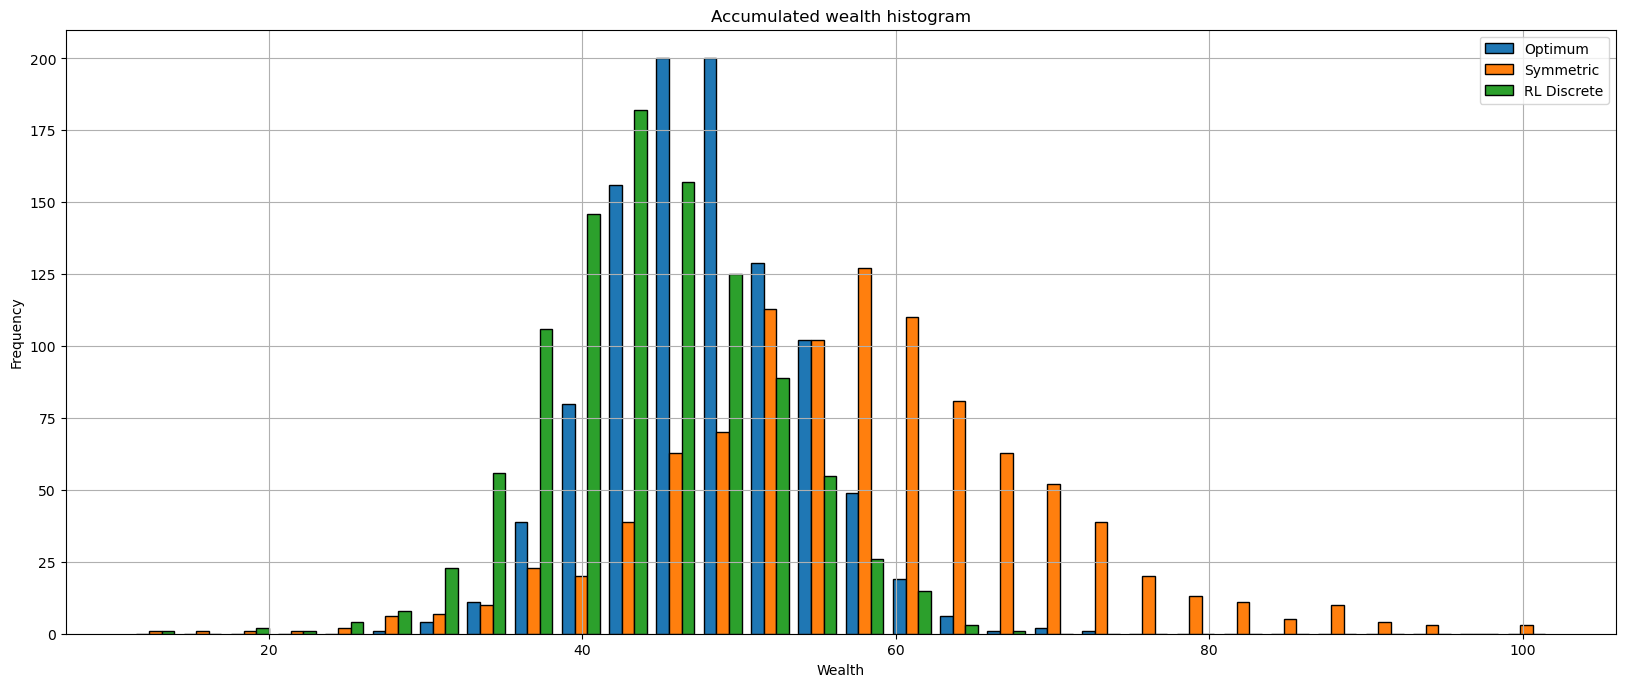

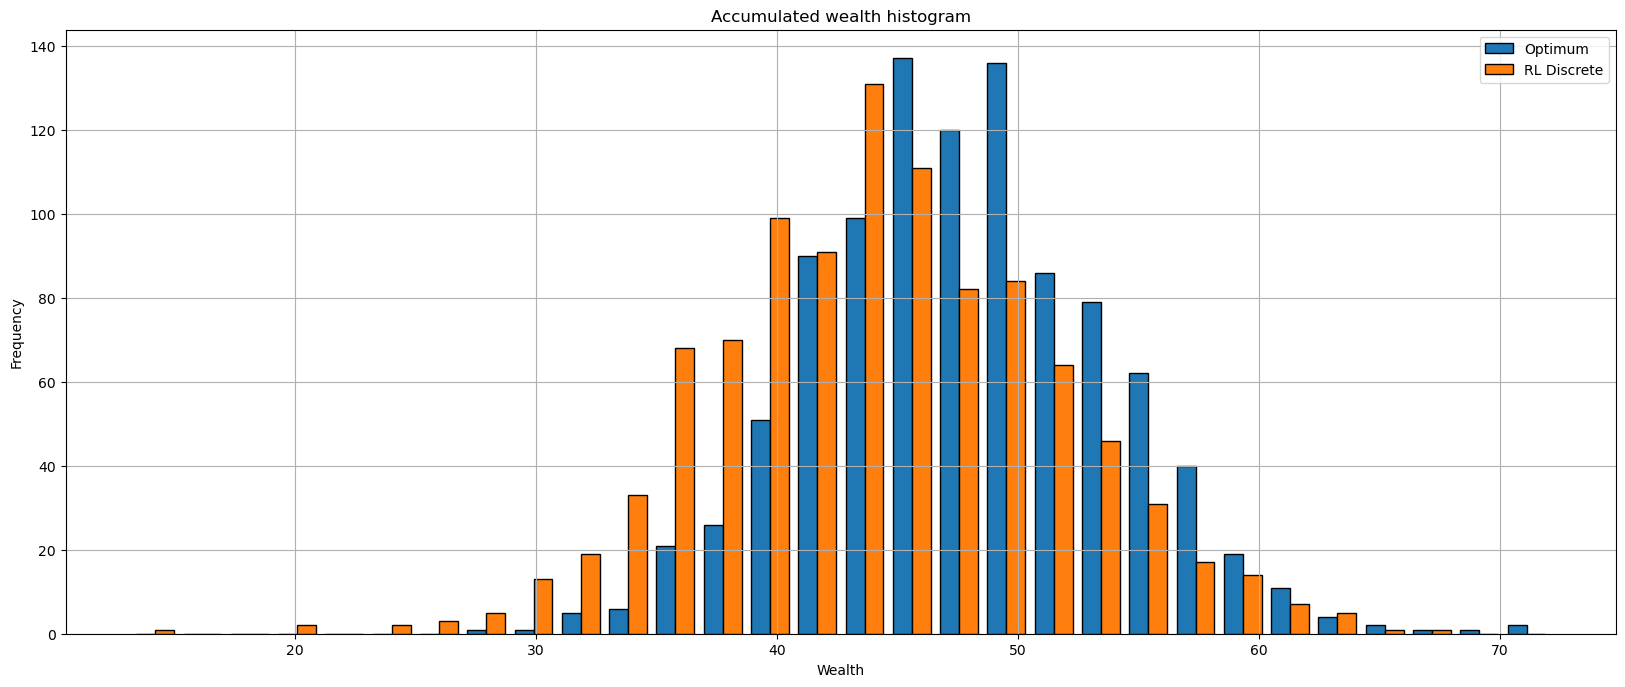

In [17]:
# Figure 2 (p. 222)
fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([ws_opt,ws_sym,ws_rl], bins=30,edgecolor='black', label=['Optimum', 'Symmetric','RL Discrete'])
plt.grid()
plt.legend()
plt.xlabel("Wealth")
plt.ylabel("Frequency")
plt.title("Accumulated wealth histogram")
fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([ws_opt,ws_rl], bins=30,edgecolor='black', label=['Optimum','RL Discrete'])
plt.grid()
plt.legend()
plt.xlabel("Wealth")
plt.ylabel("Frequency")
plt.title("Accumulated wealth histogram")

Text(0.5, 1.0, 'Accumulated reward histogram')

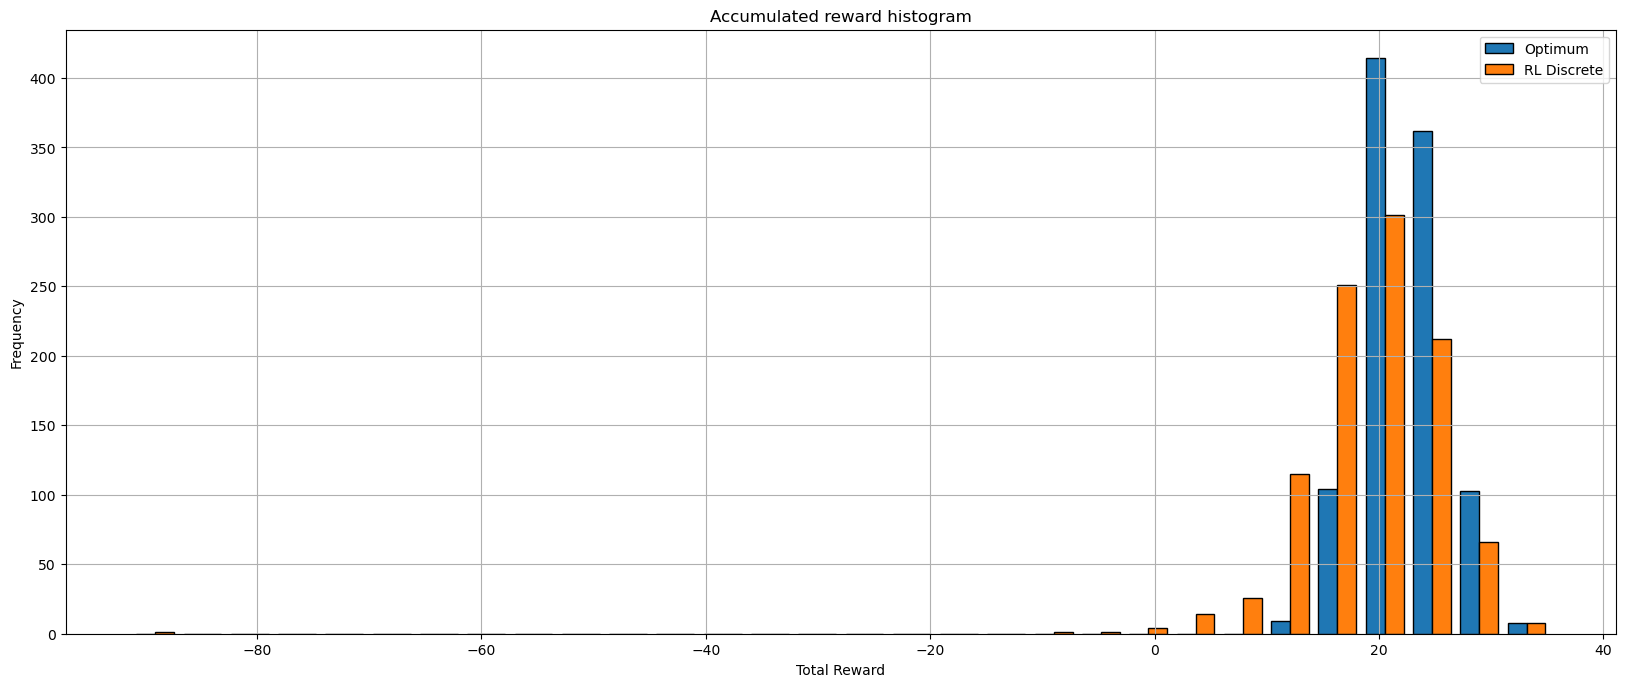

In [18]:
fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([tr_opt,tr_rl], bins=30,edgecolor='black', label=['Optimum','RL Discrete'])
plt.grid()
plt.legend()
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.title("Accumulated reward histogram")


In [19]:
print("Optimo:")
print(np.mean(ws_opt))
print(np.std(ws_opt))
print(np.mean(ws_opt)/np.std(ws_opt))
print("Simetrico:")
print(np.mean(ws_sym))
print(np.std(ws_sym))
print(np.mean(ws_sym)/np.std(ws_sym))
print("RL:")
print(np.mean(ws_rl))
print(np.std(ws_rl))
print(np.mean(ws_rl)/np.std(ws_rl))

print("Optimum utility function value: \t{:}".format(np.mean(-np.exp(-beta*ws_opt))))
print("Symmetric utility function value: \t{:}".format(np.mean(-np.exp(-beta*ws_sym))))
print("RL utility function value: \t\t{:}".format(np.mean(-np.exp(-beta*ws_rl))))

Optimo:
47.79761695404737
6.099978058681743
7.835703095033237
Simetrico:
57.6769844277537
11.8634825794015
4.861724543507817
RL:
44.21012868095298
7.0826901151634845
6.241996750119359
Optimum utility function value: 	-2.6283680458274837e-09
Symmetric utility function value: 	-4.3416792974998494e-06
RL utility function value: 		-1.4906334186553842e-06


In [20]:
print("Optimo:")
print(np.mean(tr_opt))
print(np.std(tr_opt))
print(np.mean(tr_opt)/np.std(tr_opt))

print("Simetrico:")
print(np.mean(tr_sym))
print(np.std(tr_sym))
print(np.mean(tr_sym)/np.std(tr_sym))

print("RL:")
print(np.mean(tr_rl))
print(np.std(tr_rl))
print(np.mean(tr_rl)/np.std(tr_rl))


Optimo:
22.46050972128688
3.464647237710809
6.482769580930605
Simetrico:
-7.172303914743258
42.14912649600795
-0.17016494791232661
RL:
19.191258500860183
6.555482236592922
2.927512852332043


In [12]:
import pickle

with open('./logs/qlearn', 'wb') as qlearn_file:
    pickle.dump(qlearn, qlearn_file)

qlearn_file.close()

In [21]:
import pandas as pd

trs = pd.read_csv('out_tr.csv')
trs['TAB'] = tr_rl

wss = pd.read_csv('out_ws.csv')
wss['TAB'] = ws_rl

Text(0.5, 1.0, 'Accumulated reward for $\\beta$=0.5')

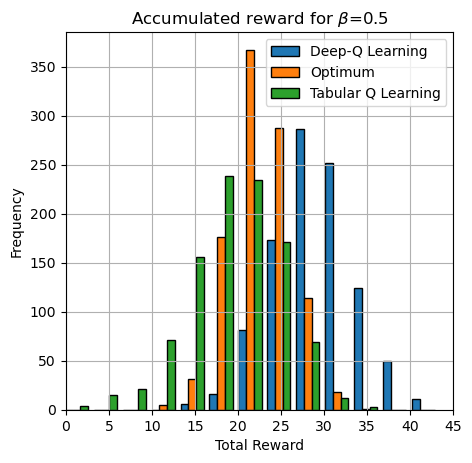

In [29]:
# Figure 2 (p. 222)
bins = 40
fig=plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([trs['DQN'],trs['OPT'],trs['TAB']], bins=bins,edgecolor='black', label=['Deep-Q Learning', 'Optimum','Tabular Q Learning'])
plt.grid()
plt.legend()
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.xlim([0,45])
plt.title("Accumulated reward for {}={}".format(r'$\beta$',beta))

Text(0.5, 1.0, 'Accumulated wealth for $\\beta$=0.5')

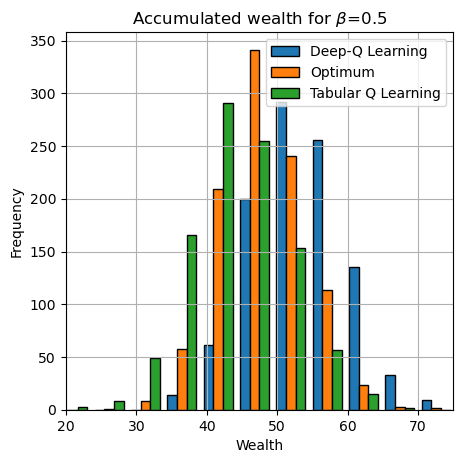

In [33]:
# Figure 2 (p. 222)
bins = 12
fig=plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([wss['DQN'],wss['OPT'],wss['TAB']], bins=bins,edgecolor='black', label=['Deep-Q Learning', 'Optimum','Tabular Q Learning'])
plt.grid()
plt.legend()
plt.xlabel("Wealth")
plt.ylabel("Frequency")
plt.xlim([20,75])
plt.title("Accumulated wealth for {}={}".format(r'$\beta$',beta))